### Install a facial landmark package for the first time

### Import packages

In [1]:
from skimage.io import imsave
import torch
from torchvision.transforms import Compose, Resize, CenterCrop
import numpy as np
from PIL import Image
import face_alignment
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from models import *
import cv2
import pdb
import glob
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### define helper functions

In [2]:
def denorm(tensor):
    return ((tensor+1.0)/2.0)*255.0

def norm(image):
    return (image/255.0-0.5)*2.0

transforms = Compose([
                CenterCrop(135),
                Resize(128)
                ])

def get_z_random(batch, nz):
    z = torch.FloatTensor(batch, nz)
    z.copy_(torch.randn(batch, nz))
    return z 


### Load input image

In [28]:
input = Image.open('images/6.jpg').convert('RGB').resize((128,128))
input = np.array(input)

### Import facial landmark algorithm

In [29]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')
preds = fa.get_landmarks(input)

### Draw landmarks on face

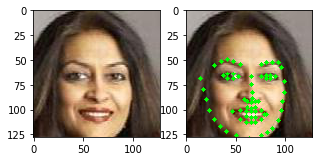

In [30]:
input_with_FL = input.copy()
for (x, y) in preds[0]:
   cv2.circle(input_with_FL, (x, y), 2, (0, 255, 0), -1)

plt.rcParams["figure.figsize"] = (5,3)
plt.subplot(1,2,1); plt.imshow(input)
plt.subplot(1,2,2); plt.imshow(input_with_FL)

### crop the face using facial landmarks

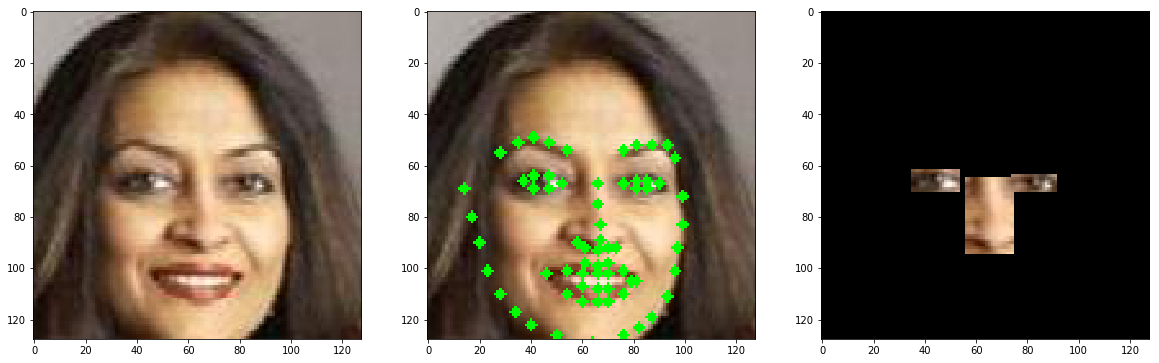

In [31]:
mask = np.zeros((input.shape[0], input.shape[1]))

############### left eye ####################
left_eye = preds[0][36:42]
n = 2
left_eye_mask = np.zeros((input.shape[0], input.shape[1]))
left_eye_mask[int(min(left_eye[:,1])-n):int(max(left_eye[:,1])+n), int(min(left_eye[:,0])-n):int(max(left_eye[:,0])+n)] = 1

############### right eye ####################
right_eye = preds[0][42:48]
n = 2
right_eye_mask = np.zeros((input.shape[0], input.shape[1]))
right_eye_mask[int(min(right_eye[:,1])-n):int(max(right_eye[:,1])+n), int(min(right_eye[:,0])-n):int(max(right_eye[:,0])+n)] = 1

############### nose ####################
nose = preds[0][27:36]
n = 2
nose_mask = np.zeros((input.shape[0], input.shape[1]))
nose_mask[int(min(nose[:,1])-n):int(max(nose[:,1])+n), int(min(nose[:,0])-n):int(max(nose[:,0])+n)] = 1

mask += left_eye_mask
mask += right_eye_mask
mask += nose_mask
mask[mask>0] = 1

crop_face = np.zeros((input.shape))
for i in range(3):
    crop_face[:,:,i] = input[:,:,i]*mask

plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,3,1); plt.imshow(input)
plt.subplot(1,3,2); plt.imshow(input_with_FL)
plt.subplot(1,3,3); plt.imshow(crop_face/255)

### Hallucinate the whole face using GAN

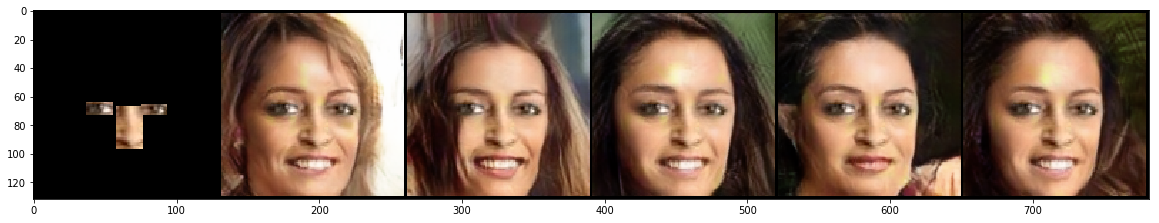

In [33]:
from models import Decoder

encoder = torch.load('models/encoder_180000.pt', map_location=lambda storage, loc: storage)
decoder = torch.load('models/decoder_180000.pt', map_location=lambda storage, loc: storage)

grid_image = np.zeros((6,128,128,3))
grid_image[0] = crop_face
for f in range(5):
    crop_face_tensor = torch.from_numpy(crop_face).unsqueeze(0).transpose(1,3).transpose(2,3).float()
    crop_face_tensor = norm(crop_face_tensor)
    
    batch = crop_face_tensor.shape[0]
    code, feats = encoder(crop_face_tensor)
    nz = 16
    z = get_z_random(batch, nz)
    
    high_hat = decoder(torch.cat([code, z], dim=1).unsqueeze(2).unsqueeze(3), feats)
    high_hat_np = denorm(high_hat).transpose(1,3).transpose(1,2).squeeze(0).data.numpy()
    
    for i in range(3):
        high_hat_np[:,:,i] = (1-mask)*high_hat_np[:,:,i] + mask*crop_face[:,:,i]
    grid_image[f+1] = high_hat_np 

grid_image = torch.from_numpy(grid_image).transpose(1,3).transpose(2,3)
demo = make_grid(grid_image, nrow=6, padding=2, normalize=True)
demo_np = demo.transpose(0,2).transpose(0,1).numpy()

plt.rcParams["figure.figsize"] = (20,10)
plt.figure(); plt.imshow(demo_np)